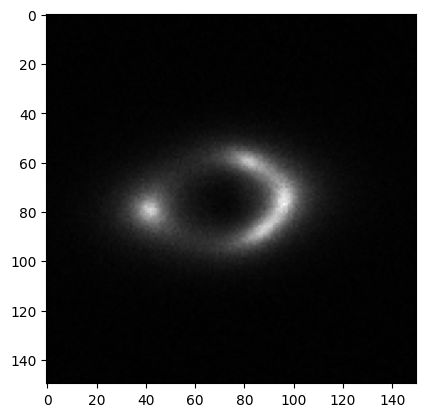

In [1]:
import numpy as np
import matplotlib.pyplot as plt


test = "Samples/sample2.npy"

img = np.load(test)
plt.imshow(img[0], cmap='gray') 
plt.show()



In [2]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os

class MyDataset(Dataset):
    def __init__(self, folder = "Samples", transform=None):
        self.data = [ np.load(f"{folder}/sample{i}.npy") for i in range(1, len(os.listdir(folder))+1) ]
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        sample = sample.reshape(150, 150,1)
        ## 3 channels
        # sample = np.concatenate([sample, sample, sample], axis=2)

        if self.transform:
            sample = self.transform(sample)
        
        return sample

preprocess = transforms.Compose(
    [   
        transforms.ToPILImage(),
        transforms.Resize((160, 160)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)


dataset = MyDataset(transform=preprocess)
print(len(dataset))


    

10000


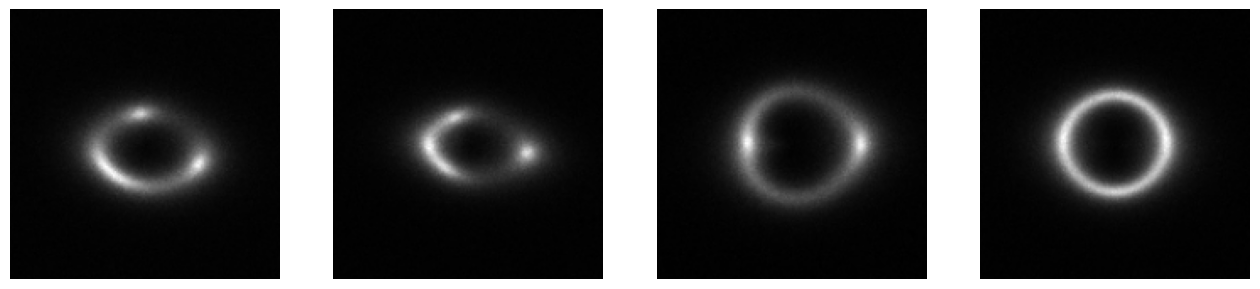

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))

for i in range(4):
    sample = dataset[i]
    sample = sample * 0.5 + 0.5
    axs[i].imshow(sample.permute(1, 2, 0).numpy() , cmap='gray')
    axs[i].axis('off')
plt.show()

In [4]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 160  # the generated image resolution
    train_batch_size = 4
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 100
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 4
    save_model_epochs = 4
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "Model_v2"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

In [5]:
train_loader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

from diffusers import UNet2DModel
import torch

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

model_path = "ddpm-butterflies-128/unet"

#Load UNet model
model.from_pretrained(model_path)

/usr/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


UNet2DModel(
  (conv_in): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

In [6]:
import torch

sample_image =torch.rand(1, 1, config.image_size, config.image_size)
print("Input shape:", sample_image.shape)

print("Output shape:", model(sample_image, timestep=0).sample.shape)


Input shape: torch.Size([1, 1, 160, 160])
Output shape: torch.Size([1, 1, 160, 160])


Noisy image shape: torch.Size([1, 1, 160, 160])
(160, 160, 1)


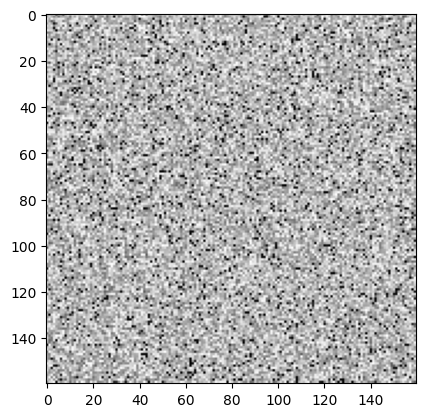

In [7]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)
print("Noisy image shape:", noisy_image.shape)
# Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])
img = noisy_image.permute(0, 2, 3, 1) + 1.0
img = img * 127.5
img = img.type(torch.uint8)
img = img.numpy()[0]
print(img.shape)

plt.imshow(img, cmap='gray')
plt.show()

In [8]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

In [9]:
from diffusers.optimization import get_cosine_schedule_with_warmup

train_dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [10]:
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.Generator(device='cpu').manual_seed(config.seed), # Use a separate torch generator to avoid rewinding the random state of the main training loop
    ).images

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [11]:
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=config.hub_model_id or Path(config.output_dir).name, exist_ok=True
            ).repo_id
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                print("Epoch", epoch, "done. Saving images")
                print("Evaluating")
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)

In [12]:
ddd

NameError: name 'ddd' is not defined

In [ ]:
from accelerate import notebook_launcher
#Load model

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


Epoch 2: 100%|██████████| 2500/2500 [12:10<00:00,  3.42it/s, loss=0.00104, lr=9.98e-5, step=7499] 


Epoch 3 done. Saving images
Evaluating


Epoch 6: 100%|██████████| 2500/2500 [11:49<00:00,  3.52it/s, loss=0.000805, lr=9.89e-5, step=17499]


Epoch 7 done. Saving images
Evaluating


Epoch 10: 100%|██████████| 2500/2500 [11:46<00:00,  3.54it/s, loss=0.000776, lr=9.71e-5, step=27499]


Epoch 11 done. Saving images
Evaluating


Epoch 14: 100%|██████████| 2500/2500 [11:46<00:00,  3.54it/s, loss=0.000522, lr=9.47e-5, step=37499]


Epoch 15 done. Saving images
Evaluating


Epoch 18: 100%|██████████| 2500/2500 [11:50<00:00,  3.52it/s, loss=0.00039, lr=9.15e-5, step=47499] 


Epoch 19 done. Saving images
Evaluating


Epoch 22: 100%|██████████| 2500/2500 [11:47<00:00,  3.54it/s, loss=0.00295, lr=8.77e-5, step=57499] 


Epoch 23 done. Saving images
Evaluating


Epoch 26: 100%|██████████| 2500/2500 [11:46<00:00,  3.54it/s, loss=0.000845, lr=8.32e-5, step=67499]


Epoch 27 done. Saving images
Evaluating


Epoch 30: 100%|██████████| 2500/2500 [12:07<00:00,  3.44it/s, loss=0.00355, lr=7.83e-5, step=77499] 


Epoch 31 done. Saving images
Evaluating


Epoch 34: 100%|██████████| 2500/2500 [12:07<00:00,  3.44it/s, loss=0.00206, lr=7.29e-5, step=87499] 


Epoch 35 done. Saving images
Evaluating


Epoch 38: 100%|██████████| 2500/2500 [12:06<00:00,  3.44it/s, loss=0.00248, lr=6.71e-5, step=97499] 


Epoch 39 done. Saving images
Evaluating


Epoch 42: 100%|██████████| 2500/2500 [12:06<00:00,  3.44it/s, loss=0.000295, lr=6.11e-5, step=107499]


Epoch 43 done. Saving images
Evaluating


Epoch 46: 100%|██████████| 2500/2500 [12:06<00:00,  3.44it/s, loss=0.000112, lr=5.49e-5, step=117499]


Epoch 47 done. Saving images
Evaluating


Epoch 50: 100%|██████████| 2500/2500 [12:06<00:00,  3.44it/s, loss=0.0142, lr=4.86e-5, step=127499]  


Epoch 51 done. Saving images
Evaluating


Epoch 54: 100%|██████████| 2500/2500 [12:48<00:00,  3.25it/s, loss=0.000276, lr=4.24e-5, step=137499]


Epoch 55 done. Saving images
Evaluating


Epoch 58: 100%|██████████| 2500/2500 [13:03<00:00,  3.19it/s, loss=0.000404, lr=3.62e-5, step=147499]


Epoch 59 done. Saving images
Evaluating


Epoch 62: 100%|██████████| 2500/2500 [11:45<00:00,  3.54it/s, loss=0.00118, lr=3.03e-5, step=157499] 


Epoch 63 done. Saving images
Evaluating


Epoch 66: 100%|██████████| 2500/2500 [11:45<00:00,  3.54it/s, loss=0.0001, lr=2.47e-5, step=167499]  


Epoch 67 done. Saving images
Evaluating


Epoch 70: 100%|██████████| 2500/2500 [11:45<00:00,  3.54it/s, loss=0.000294, lr=1.95e-5, step=177499]


Epoch 71 done. Saving images
Evaluating


Epoch 74: 100%|██████████| 2500/2500 [11:45<00:00,  3.54it/s, loss=0.000703, lr=1.47e-5, step=187499]


Epoch 75 done. Saving images
Evaluating


Epoch 78: 100%|██████████| 2500/2500 [11:45<00:00,  3.54it/s, loss=0.000237, lr=1.06e-5, step=197499]


Epoch 79 done. Saving images
Evaluating


Epoch 82: 100%|██████████| 2500/2500 [11:45<00:00,  3.54it/s, loss=0.000215, lr=7.02e-6, step=207499]


Epoch 83 done. Saving images
Evaluating


Epoch 86: 100%|██████████| 2500/2500 [11:30<00:00,  3.62it/s, loss=0.00059, lr=4.15e-6, step=217499] 


Epoch 87 done. Saving images
Evaluating


Epoch 90: 100%|██████████| 2500/2500 [11:30<00:00,  3.62it/s, loss=0.000138, lr=2.01e-6, step=227499]


Epoch 91 done. Saving images
Evaluating


Epoch 94: 100%|██████████| 2500/2500 [11:30<00:00,  3.62it/s, loss=0.000243, lr=6.28e-7, step=237499]


Epoch 95 done. Saving images
Evaluating


Epoch 98: 100%|██████████| 2500/2500 [12:00<00:00,  3.47it/s, loss=0.000235, lr=2.68e-8, step=247499]


Epoch 99 done. Saving images
Evaluating


Epoch 99: 100%|██████████| 2500/2500 [18:09<00:00,  2.29it/s, loss=0.072, lr=4.21e-11, step=249999]


In [ ]:
#Save model
pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)
pipeline.save_pretrained("FINAL_MODEL_V1")


In [13]:
#Load pipleine 
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained("FINAL_MODEL_V1")
print(pipeline)

Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00,  6.50it/s]

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "FINAL_MODEL_V1",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}



In [14]:
from torchmetrics.image.fid import FrechetInceptionDistance


def calculate_fid(real_images, generated_images):
    fid = FrechetInceptionDistance(normalize=True)
    fid.update(real_images,real = True)
    fid.update(generated_images,real = False)
    return fid.compute()

In [17]:
#FID of 1 image
device = "cuda" if torch.cuda.is_available() else "cpu"
pipeline = pipeline.to(device)
generated_images = pipeline(
    batch_size=32,
    generator=torch.Generator(device=device).manual_seed(42),
    output_type="np",
).images



generated_images = torch.Tensor(generated_images).permute(0, 3, 1, 2)
# generated_images = torch.cat([generated_images, generated_images, generated_images], dim=1)




100%|██████████| 1000/1000 [15:31<00:00,  1.07it/s]


In [18]:
real_images = []
for i in range(32):
    real_images.append(dataset[i].permute(1, 2, 0).numpy())

real_images = torch.Tensor(real_images).permute(0, 3, 1, 2)
print(real_images.shape)

torch.Size([32, 1, 160, 160])


/tmp/ipykernel_137447/3643508893.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  real_images = torch.Tensor(real_images).permute(0, 3, 1, 2)


In [20]:
real_images = torch.cat([real_images, real_images, real_images], dim=1)


In [19]:
generated_images = torch.cat([generated_images, generated_images, generated_images], dim=1)

In [21]:
generated_images.shape, real_images.shape

(torch.Size([32, 3, 160, 160]), torch.Size([32, 3, 160, 160]))

In [22]:
fid = calculate_fid(real_images, generated_images)
print(fid)

tensor(316.3120)
